In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from classesEmulation import dataType
from functions import get_eff_faker_err, train_test_split_by_part, get_eff_faker_vs_feat
import xgboost as xgb
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import awkward as ak
import random
import math
from fxpmath import Fxp

In [2]:
# -----IMPORT DATA-----
# take in .root into arrays
arrays_hybrid_darkPhoton = uproot.open("D95_DarkPhoton_mH125_mGammaD20_cT10_EmulationFix_Train.root")["L1TrackNtuple/eventTree"].arrays(
['trkExtEmuFixed_pt',
 'trkExtEmuFixed_eta',
 'trkExtEmuFixed_phi',
 'trkExtEmuFixed_d0',
 'trkExtEmuFixed_z0',
 'trkExtEmuFixed_chi2rz',
 'trkExtEmuFixed_bendchi2',
 'trkExtEmuFixed_MVA',
 'dvEmuFixed_d_T',
 'dvEmu_R_T',
 'dvEmuFixed_R_T',
 'dvEmuFixed_cos_T',
 'dvEmuFixed_del_Z',
 'dvEmu_firstIndexTrk',
 'dvEmu_secondIndexTrk',
 'dvEmu_isReal'],library="ak")
arrays_hybrid_darkPhoton100 = uproot.open("D95_DarkPhoton_mH125_mGammaD20_cT100_EmulationFix_Train.root")["L1TrackNtuple/eventTree"].arrays(
['trkExtEmuFixed_pt',
 'trkExtEmuFixed_eta',
 'trkExtEmuFixed_phi',
 'trkExtEmuFixed_d0',
 'trkExtEmuFixed_z0',
 'trkExtEmuFixed_chi2rz',
 'trkExtEmuFixed_bendchi2',
 'trkExtEmuFixed_MVA',
 'dvEmuFixed_d_T',
 'dvEmu_R_T',
 'dvEmuFixed_R_T',
 'dvEmuFixed_cos_T',
 'dvEmuFixed_del_Z',
 'dvEmu_firstIndexTrk',
 'dvEmu_secondIndexTrk',
 'dvEmu_isReal'],library="ak")
#arrays_hybrid_darkPhotonLL = uproot.open("DarkPhoton_cT100_Train.root")["L1TrackNtuple/eventTree"].arrays(library="ak")
arrays_hybrid_neutrinoGun = uproot.open("D95_NeutrinoGun_EmulationFix_TrainSkim.root")["eventTree"].arrays(
['trkExtEmuFixed_pt',
 'trkExtEmuFixed_eta',
 'trkExtEmuFixed_phi',
 'trkExtEmuFixed_d0',
 'trkExtEmuFixed_z0',
 'trkExtEmuFixed_chi2rz',
 'trkExtEmuFixed_bendchi2',
 'trkExtEmuFixed_MVA',
 'dvEmuFixed_d_T',
 'dvEmu_R_T',
 'dvEmuFixed_R_T',
 'dvEmuFixed_cos_T',
 'dvEmuFixed_del_Z',
 'dvEmu_firstIndexTrk',
 'dvEmu_secondIndexTrk',
 'dvEmu_isReal'],library="ak")#[:65000]
print("dark photon cT 10 length:",len(arrays_hybrid_darkPhoton))
print("dark photon cT 100 length:",len(arrays_hybrid_darkPhoton100))
print("neutrino gun length:",len(arrays_hybrid_neutrinoGun))
#print("dark photon cT 100 length:",len(arrays_hybrid_darkPhotonLL))

# create data in proper format
data_darkPhoton = dataType(arrays_hybrid_darkPhoton)
data_darkPhoton100= dataType(arrays_hybrid_darkPhoton100)
data_neutrinoGun = dataType(arrays_hybrid_neutrinoGun)
#data_darkPhotonLL = dataType(arrays_hybrid_darkPhotonLL)

dark photon cT 10 length: 23350
dark photon cT 100 length: 23727
neutrino gun length: 216103


In [12]:
arrays_hybrid_darkPhoton = uproot.open("GTTObjects_Test.root")["L1TrackNtuple/eventTree"].arrays(
['trkExtEmu_pt',
 'trkExtEmu_eta',
 'trkExtEmu_phi',
 'trkExtEmu_d0',
 'trkExtEmu_z0',
 'trkExtEmu_chi2rphi',
 'trkExtEmu_chi2rz',
 'trkExtEmu_bendchi2',
 'trkExtEmu_MVA',
 'dvEmu_d_T',
 'dvEmu_R_T',
 'dvEmu_cos_T',
 'dvEmu_del_Z',
 'dvEmu_firstIndexTrk',
 'dvEmu_secondIndexTrk',
 'dvEmu_isReal'],library="ak")
data_darkPhoton = dataType(arrays_hybrid_darkPhoton)

In [13]:
print(arrays_hybrid_darkPhoton["trkExtEmu_d0"][arrays_hybrid_darkPhoton["dvEmu_firstIndexTrk"][arrays_hybrid_darkPhoton["dvEmu_isReal"]]].to_list())
print(arrays_hybrid_darkPhoton["trkExtEmu_d0"][arrays_hybrid_darkPhoton["dvEmu_secondIndexTrk"][arrays_hybrid_darkPhoton["dvEmu_isReal"]]].to_list())
print(data_darkPhoton.verts.X[(data_darkPhoton.verts.isReal==1)][0].to_list())
print(clf_GBDT.predict_proba(data_darkPhoton.verts.X[(data_darkPhoton.verts.isReal==1)])[:,1])

[[], [-0.431640625, -0.439453125, -0.083984375]]
[[], [2.599609375, 2.599609375, 0.169921875]]
[29.75, 4.875, 0.375, 1.25, 0.25, -1.25, 0.4375, -2.625, -4.5625, -4.75, 0.5, 1.0, 0.0, 5.0, 0.875, 0.875, 0.0, 2.6875, 1.0, 6.8125]


NameError: name 'clf_GBDT' is not defined

In [11]:
print(Fxp(1.25,True,3,1,overflow="saturate",rounding="around"))

1.0


In [3]:
print("darkPhoton cT 10 number of vertices:",ak.sum(ak.num(arrays_hybrid_darkPhoton['dvEmu_isReal'],axis=1)))
n_signal = ak.sum((arrays_hybrid_darkPhoton['dvEmu_isReal']==1) & (arrays_hybrid_darkPhoton['dvEmu_R_T']<20) & (arrays_hybrid_darkPhoton['dvEmu_R_T']>0.02152))
n_fake_darkPhoton = ak.sum((arrays_hybrid_darkPhoton['dvEmu_isReal']==0) & (arrays_hybrid_darkPhoton['dvEmu_R_T']<20) & (arrays_hybrid_darkPhoton['dvEmu_R_T']>0.02152))
print("num real:",n_signal,"num fake:",n_fake_darkPhoton)
print("darkPhoton cT 100 number of vertices:",ak.sum(ak.num(arrays_hybrid_darkPhoton100['dvEmu_isReal'],axis=1)))
n_signal100 = ak.sum((arrays_hybrid_darkPhoton100['dvEmu_isReal']==1) & (arrays_hybrid_darkPhoton100['dvEmu_R_T']<20) & (arrays_hybrid_darkPhoton100['dvEmu_R_T']>0.02152))
n_fake_darkPhoton100 = ak.sum((arrays_hybrid_darkPhoton100['dvEmu_isReal']==0) & (arrays_hybrid_darkPhoton100['dvEmu_R_T']<20) & (arrays_hybrid_darkPhoton100['dvEmu_R_T']>0.02152))
print("num real:",n_signal100,"num fake:",n_fake_darkPhoton100)
print("neutrinoGun number of vertices:",ak.sum(ak.num(arrays_hybrid_neutrinoGun['dvEmu_isReal'],axis=1)))
n_fake_neutrinoGun = ak.sum((arrays_hybrid_neutrinoGun['dvEmu_isReal']==0) & (arrays_hybrid_neutrinoGun['dvEmu_R_T']<20) & (arrays_hybrid_neutrinoGun['dvEmu_R_T']>0.02152))
print("num real:",ak.sum((arrays_hybrid_neutrinoGun['dvEmu_isReal']==1) & (arrays_hybrid_neutrinoGun['dvEmu_R_T']<20) & (arrays_hybrid_neutrinoGun['dvEmu_R_T']>0.02152)),"num fake:",n_fake_neutrinoGun)
#print("darkPhoton cT 100 number of vertices:",ak.sum(ak.num(arrays_hybrid_darkPhotonLL['dv_isReal'],axis=1)))
#n_signalLL = ak.sum(arrays_hybrid_darkPhotonLL['dv_isReal']==1)
#n_fake_darkPhotonLL = ak.sum(arrays_hybrid_darkPhotonLL['dv_isReal']==0)
#print("num real:",n_signalLL,"num fake:",n_fake_darkPhotonLL)

darkPhoton cT 10 number of vertices: 2368754
num real: 22263 num fake: 2346491
darkPhoton cT 100 number of vertices: 2146265
num real: 12794 num fake: 2133471
neutrinoGun number of vertices: 12212212
num real: 0 num fake: 12212211


In [4]:
# -----CREATE TRAIN AND TEST DATA SET-----
real_idx_darkPhoton = sample_without_replacement(n_signal,n_signal/2,random_state=23)
real_idx_darkPhoton100 = sample_without_replacement(n_signal100,n_signal100/2,random_state=23)
fake_idx_neutrinoGun = sample_without_replacement(n_fake_neutrinoGun,n_fake_neutrinoGun/2,random_state=23)
X_train = ak.concatenate((data_darkPhoton.verts.X[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)][real_idx_darkPhoton],
                          data_darkPhoton100.verts.X[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)][real_idx_darkPhoton100],
                          data_neutrinoGun.verts.X[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)][fake_idx_neutrinoGun]))
y_train = ak.concatenate((data_darkPhoton.verts.y[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)][real_idx_darkPhoton],
                          data_darkPhoton100.verts.y[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)][real_idx_darkPhoton100],
                          data_neutrinoGun.verts.y[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)][fake_idx_neutrinoGun]))
R_T_train = ak.concatenate((data_darkPhoton.verts.R_T[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)][real_idx_darkPhoton],data_darkPhoton100.verts.R_T[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)][real_idx_darkPhoton100],data_neutrinoGun.verts.R_T[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)][fake_idx_neutrinoGun]))
X_train,y_train,R_T_train = shuffle(X_train,y_train,R_T_train,random_state=23)

# all other tracks make up testing set
X_test = ak.concatenate((np.delete(data_darkPhoton.verts.X[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)],real_idx_darkPhoton,axis=0),
                         np.delete(data_darkPhoton100.verts.X[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)],real_idx_darkPhoton100,axis=0),
                         np.delete(data_neutrinoGun.verts.X[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)],fake_idx_neutrinoGun,axis=0)))
y_test = ak.concatenate((np.delete(data_darkPhoton.verts.y[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)],real_idx_darkPhoton,axis=0),
                         np.delete(data_darkPhoton100.verts.y[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)],real_idx_darkPhoton100,axis=0),
                         np.delete(data_neutrinoGun.verts.y[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)],fake_idx_neutrinoGun,axis=0)))
R_T_test = ak.concatenate((np.delete(data_darkPhoton.verts.R_T[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)],real_idx_darkPhoton,axis=0),
                           np.delete(data_darkPhoton100.verts.R_T[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)],real_idx_darkPhoton100,axis=0),
                           np.delete(data_neutrinoGun.verts.R_T[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)],fake_idx_neutrinoGun,axis=0)))
X_test,y_test,R_T_test = shuffle(X_test,y_test,R_T_test,random_state=23)

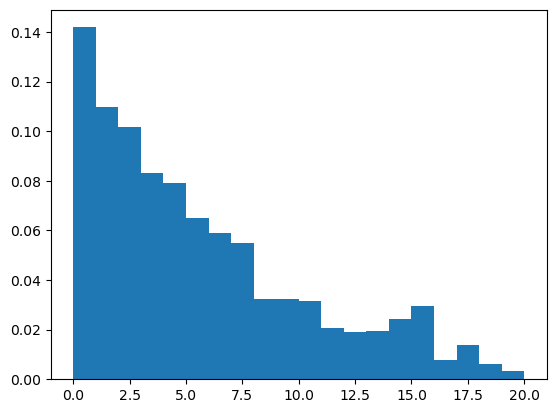

(array([0.14192894, 0.10994469, 0.10162416, 0.08336332, 0.07898115,
       0.06516979, 0.05889345, 0.05487525, 0.03246039, 0.03236752,
       0.0314503 , 0.02073002, 0.01887272, 0.01965857, 0.0245026 ,
       0.02935773, 0.00788319, 0.01368753, 0.00601168, 0.00340903]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.]), <BarContainer object of 20 artists>)


In [13]:
darkPhotonTrain = data_darkPhoton.verts.X[(data_darkPhoton.verts.isReal==1) & (data_darkPhoton.verts.R_T<20) & (data_darkPhoton.verts.R_T>0.02152)][real_idx_darkPhoton]
darkPhotonTrain_RT = [x[19] for x in darkPhotonTrain]
weighted_RT = [(1+1.3*x)**1.8 for x in darkPhotonTrain_RT]
weighted_RT /= np.sum(weighted_RT)
hist_val = plt.hist(darkPhotonTrain_RT,bins=np.linspace(0,20,21),weights=weighted_RT)
plt.show()
print(hist_val)

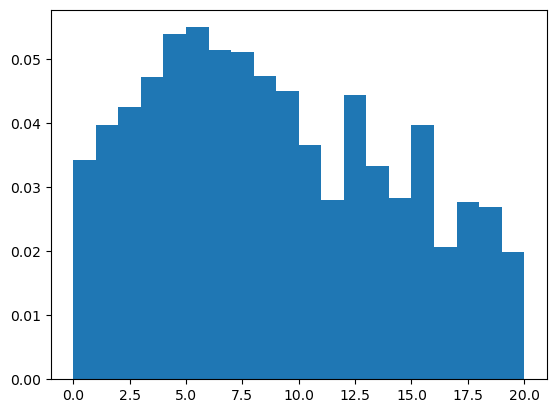

(array([0.03424231, 0.03966946, 0.04257435, 0.04719151, 0.05396698,
       0.05494608, 0.05137019, 0.05103311, 0.04735837, 0.04498837,
       0.03657432, 0.02802528, 0.04432058, 0.03331782, 0.02833731,
       0.03970466, 0.02067899, 0.02764995, 0.02690791, 0.01986429]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.]), <BarContainer object of 20 artists>)


In [14]:
darkPhoton100Train = data_darkPhoton100.verts.X[(data_darkPhoton100.verts.isReal==1) & (data_darkPhoton100.verts.R_T<20) & (data_darkPhoton100.verts.R_T>0.02152)][real_idx_darkPhoton100]
darkPhoton100Train_RT = [x[19] for x in darkPhoton100Train]
weighted100_RT = [(1+1.3*x)**1.8 for x in darkPhoton100Train_RT]
weighted100_RT /= np.sum(weighted100_RT)
hist_val = plt.hist(darkPhoton100Train_RT,bins=np.linspace(0,20,21),weights=weighted100_RT)
plt.show()
print(hist_val)

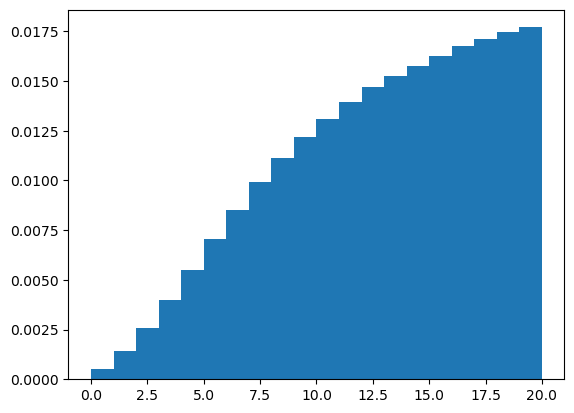

(array([0.00053713, 0.00142377, 0.00260029, 0.0039879 , 0.00550838,
       0.00703768, 0.00851633, 0.00989943, 0.011115  , 0.01220718,
       0.01310238, 0.01395691, 0.0146784 , 0.01524374, 0.015765  ,
       0.01627748, 0.01676806, 0.01709348, 0.0174684 , 0.01769929]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.]), <BarContainer object of 20 artists>)


In [15]:
neutrinoTrain = data_neutrinoGun.verts.X[(data_neutrinoGun.verts.isReal==0) & (data_neutrinoGun.verts.R_T<20) & (data_neutrinoGun.verts.R_T>0.02152)][fake_idx_neutrinoGun]
neutrinoTrain_RT = [x[19] for x in neutrinoTrain]
weightedNeutrino_RT = [(1+1.3*x)**1.8 for x in neutrinoTrain_RT]
weightedNeutrino_RT /= np.sum(weightedNeutrino_RT)
hist_val = plt.hist(neutrinoTrain_RT,bins=np.linspace(0,20,21),weights=weightedNeutrino_RT)
plt.show()
print(hist_val)

(array([3644347., 1014518.,  667353.,  395248.,  204742.,   96709.,
          50262.,   27568.,   14453.,    5881.]),
 array([ 0.     ,  1.99375,  3.9875 ,  5.98125,  7.975  ,  9.96875,
        11.9625 , 13.95625, 15.95   , 17.94375, 19.9375 ]),
 <BarContainer object of 10 artists>)

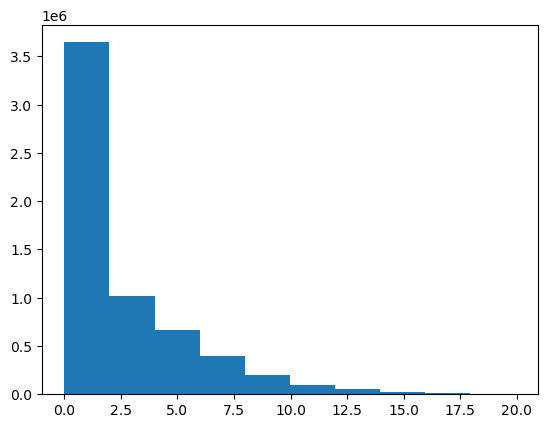

In [5]:
d_T = [x[16] for x in X_train]
plt.hist(d_T)

In [5]:
print(data_darkPhoton.verts.X_feats)
R_T = [x[17] for x in X_train]
#d0_weights = [0.1*pow(abs(x[6]),2) for x in X_train]

['trkExtEmuFixed_pt_firstTrk', 'trkExtEmuFixed_pt', 'trkExtEmuFixed_eta_firstTrk', 'trkExtEmuFixed_eta', 'trkExtEmuFixed_phi_firstTrk', 'trkExtEmuFixed_phi', 'trkExtEmuFixed_d0_firstTrk', 'trkExtEmuFixed_d0', 'trkExtEmuFixed_z0_firstTrk', 'trkExtEmuFixed_z0', 'trkExtEmuFixed_chi2rz_firstTrk', 'trkExtEmuFixed_chi2rz', 'trkExtEmuFixed_bendchi2_firstTrk', 'trkExtEmuFixed_bendchi2', 'trkExtEmuFixed_MVA_firstTrk', 'trkExtEmuFixed_MVA', 'dvEmuFixed_d_T', 'dvEmuFixed_R_T', 'dvEmuFixed_cos_T', 'dvEmuFixed_del_Z']


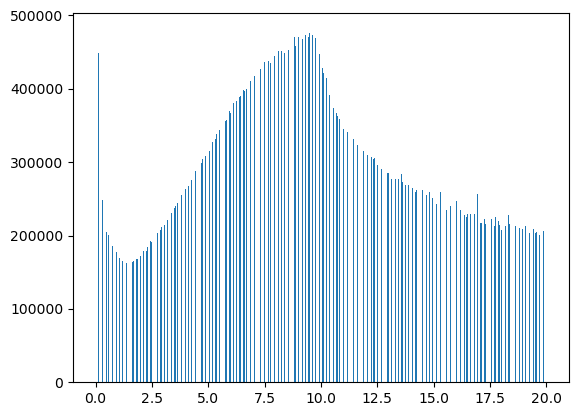

(array([     0.        ,      0.        ,      0.        ,  61092.44259593,
            0.        ,      0.        , 448253.55014718,      0.        ,
            0.        , 364414.30406505,      0.        ,      0.        ,
       283056.85755943,      0.        ,      0.        , 248195.23535144,
            0.        ,      0.        , 228634.90251463,      0.        ,
            0.        , 215141.30187512,      0.        ,      0.        ,
       205187.63202868,      0.        ,      0.        ,      0.        ,
       200166.015625  ,      0.        ,      0.        , 194087.00728864,
            0.        ,      0.        , 189577.31807872,      0.        ,
            0.        , 185089.15518712,      0.        ,      0.        ,
       183140.78834099,      0.        ,      0.        , 181362.06440445,
            0.        ,      0.        , 177091.01021007,      0.        ,
            0.        , 174502.63988837,      0.        ,      0.        ,
            0.        , 

In [6]:
#weight = [(1+1.3*x)**1.8 for x in R_T]
weight = [(1+x)**1.5 for x in R_T]
bins = plt.hist(R_T,bins=np.linspace(0,20,1000),weights=weight)
#plt.yscale('log')
plt.show()
print(bins)

In [7]:
for i in range(len(data_darkPhoton.verts.X_feats)):
    print("Feature:",data_darkPhoton.verts.X_feats[i])
    feat = [x[i] for x in X_train]
    print("values:",feat[:10])

Feature: trkExtEmu_pt_firstTrk
values: [3.375, 12.0, 4.875, 3.125, 4.125, 3.5, 3.125, 3.625, 3.75, 4.625]
Feature: trkExtEmu_pt
values: [3.5, 3.25, 3.25, 4.0, 3.5, 3.25, 3.75, 3.875, 5.875, 3.125]
Feature: trkExtEmu_eta_firstTrk
values: [1.625, -0.5625, 0.0625, 1.6875, 0.8125, -1.0, -0.375, 0.9375, 1.5625, 0.875]
Feature: trkExtEmu_eta
values: [0.3125, 1.6875, -0.8125, -0.125, 1.875, 0.6875, -1.125, 2.25, -0.625, 1.5]
Feature: trkExtEmu_phi_firstTrk
values: [1.25, 0.3125, 2.875, -2.8125, 0.625, -2.8125, -0.3125, -2.9375, 0.5, -2.0]
Feature: trkExtEmu_phi
values: [2.75, 2.5625, -1.25, -0.9375, 1.5, -0.25, -2.0, -0.875, 1.25, -1.1875]
Feature: trkExtEmu_d0_firstTrk
values: [-0.875, -3.4375, 7.375, 0.0625, 1.6875, 0.125, -0.0625, 0.0625, 0.0625, 1.0]
Feature: trkExtEmu_d0
values: [1.25, 0.0625, 0.0625, 0.0625, -0.0625, -0.0625, -0.9375, 0.0625, 5.4375, 0.0625]
Feature: trkExtEmu_z0_firstTrk
values: [-3.9375, 5.1875, 11.8125, 0.0, 7.3125, -2.75, -2.375, 1.25, 4.875, -4.875]
Feature: trkExt

In [8]:
evaluation = [(X_test, y_test)]

In [7]:
#weights = [0.1*pow(abs(x[6]),2) for x in X_train]
# -----TRAIN MODEL-----
# train gbdt with 100 trees and a max depth of 5
clf_GBDT = xgb.XGBClassifier(n_estimators=50, learning_rate=0.4, max_depth=4, random_state=23,gamma=3.0,tree_method="hist")
clf_GBDT.fit(X_train,y_train,sample_weight=weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

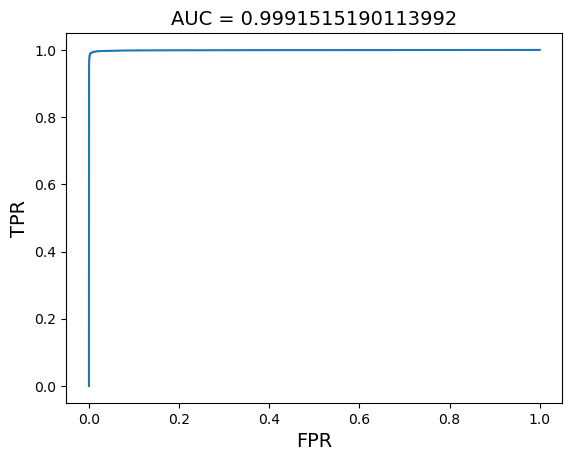

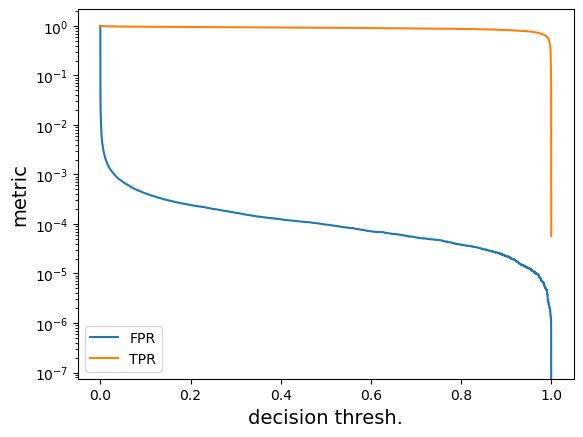

In [8]:
# -----EVALUATE MODEL-----

# Create roc curve with AUC (area under curve) value
y_pred = clf_GBDT.predict_proba(X_test)[:,1]
fpr, tpr, dt = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.title('AUC = '+str(auc),fontsize=14)
plt.show()
plt.close()

# Plot TPR and FPR vs decision threshold (dt)
plt.semilogy(dt[1:],fpr[1:],label='FPR')
plt.semilogy(dt[1:],tpr[1:],label='TPR')
plt.xlabel('decision thresh.',fontsize=14)
plt.ylabel('metric',fontsize=14)
plt.legend(loc='best')
plt.show()
plt.close()

In [19]:
print("fpr",repr(fpr[::1000]))
print("tpr",repr(tpr[::1000]))

fpr array([0.00000000e+00, 0.00000000e+00, 5.00273024e-07, 7.50409536e-06,
       1.72344057e-04, 9.23504002e-04, 2.61167532e-03, 4.31435456e-03,
       6.13784973e-03, 7.81201341e-03, 9.47542121e-03, 1.10720426e-02,
       1.25923723e-02, 1.40569216e-02, 1.54506822e-02, 1.69099786e-02,
       1.83132445e-02, 1.96016976e-02, 2.09019072e-02, 2.22196264e-02,
       2.35248387e-02, 2.48323022e-02, 2.61297603e-02, 2.73344178e-02,
       2.85303204e-02, 2.97234716e-02, 3.10344370e-02, 3.23644129e-02,
       3.36070911e-02, 3.48695300e-02, 3.60844431e-02, 3.73051093e-02,
       3.85332795e-02, 3.97669528e-02, 4.09355906e-02, 4.21745167e-02,
       4.34307023e-02, 4.46248540e-02, 4.57049435e-02, 4.68122978e-02,
       4.79596740e-02, 4.93591878e-02, 5.05700986e-02, 5.18050226e-02,
       5.30331929e-02, 5.42913795e-02, 5.53967328e-02, 5.67332122e-02,
       5.78012951e-02, 5.90094544e-02, 6.02036061e-02, 6.14290249e-02,
       6.26456889e-02, 6.40019291e-02, 6.53306542e-02, 6.65500697e-02,
  

In [9]:
def get_eff_faker_vs_feat(feat_interest, feat, X, y, fit_clf, thresh=.5):
    
    if feat_interest=='pt':  
        feat_bins = np.logspace(1.3,2,12) #2 to 100 GeV in log bins
    elif feat_interest=='eta':   
        feat_bins = np.linspace(-2.5,2.5,30)
    elif feat_interest=='R_T':
        feat_bins = np.logspace(-1,1.301,20)
    else:
        feat_bins= np.linspace(0,100,100)
    # add another feature to study here

    eff = np.zeros(len(feat_bins)-1)
    faker = np.zeros(len(feat_bins)-1)
    err_eff = np.zeros(len(feat_bins)-1)
    err_faker = np.zeros(len(feat_bins)-1)
    X = np.array(X)
    y = np.array(y)
    for ii in range(1,len(feat_bins)):
        idx_temp = np.digitize(feat,feat_bins,right=True)==ii
        X_temp = X[idx_temp]
        y_temp = y[idx_temp]
        if len(X_temp)>0:
            try: #works for keras
                y_pred = (fit_clf.predict(X_temp)[:,0]>thresh)*1
            except: #works for sklearn & xgboost
                y_pred = (fit_clf.predict_proba(X_temp)[:,1]>thresh)*1
            eff[ii-1], faker[ii-1], err_eff[ii-1], err_faker[ii-1] = get_eff_faker_err(y_pred,y_temp)

    # correct bin to be centered and error is bin width
    bins = [(feat_bins[i]+feat_bins[i+1])/2 for i in range(len(feat_bins)-1)]
    bins_err = [(feat_bins[i+1]-feat_bins[i])/2 for i in range(len(feat_bins)-1)]        
    
    return bins, bins_err, eff, faker, err_eff, err_faker

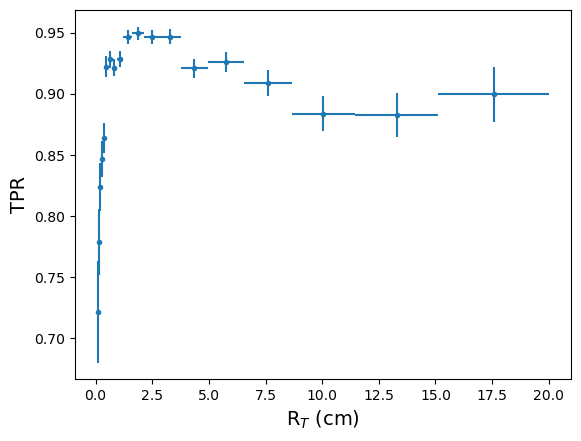

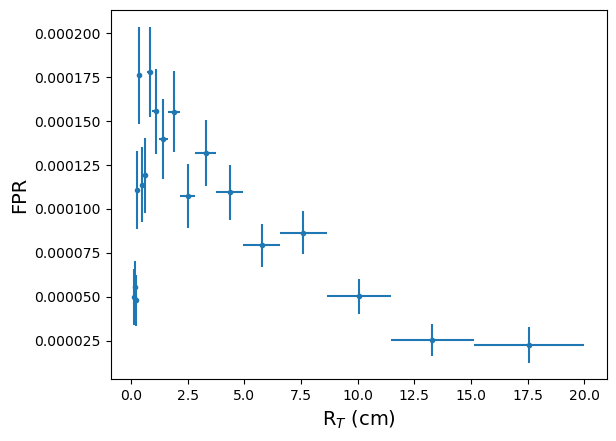

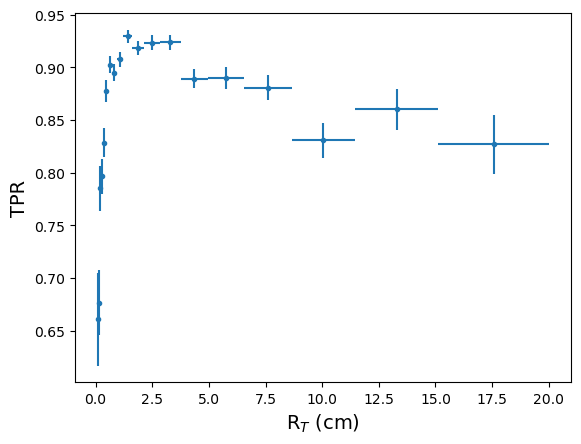

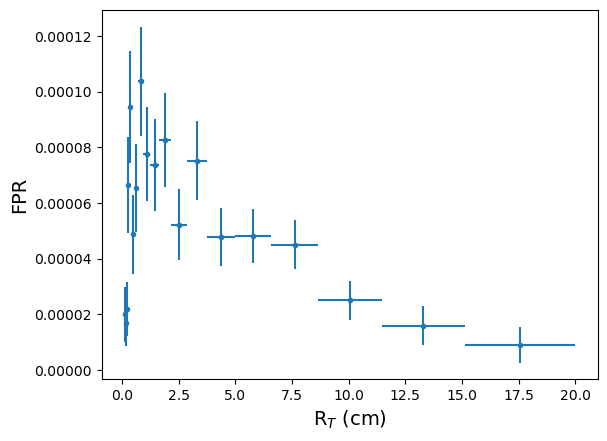

In [10]:
pt, pt_err, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('R_T',R_T_test,X_test,y_test,clf_GBDT)
plt.errorbar(pt,eff,yerr=err_eff,xerr=pt_err,linestyle='None',fmt='.')
plt.xlabel('R$_{T}$ (cm)',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()
#plt.savefig('TPR_vs_pt.png')
plt.errorbar(pt,faker,yerr=err_faker,xerr=pt_err,linestyle='None',fmt='.')
plt.xlabel('R$_{T}$ (cm)',fontsize=14)
plt.ylabel('FPR',fontsize=14)
plt.show()
pt, pt_err, eff, faker, err_eff, err_faker = get_eff_faker_vs_feat('R_T',R_T_test,X_test,y_test,clf_GBDT,0.72)
plt.errorbar(pt,eff,yerr=err_eff,xerr=pt_err,linestyle='None',fmt='.')
plt.xlabel('R$_{T}$ (cm)',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()
#plt.savefig('TPR_vs_pt.png')
plt.errorbar(pt,faker,yerr=err_faker,xerr=pt_err,linestyle='None',fmt='.')
plt.xlabel('R$_{T}$ (cm)',fontsize=14)
plt.ylabel('FPR',fontsize=14)
plt.show()

In [11]:
print("pt",pt)
print("pt_err",pt_err)
print("eff",eff)
print("faker",faker)
print("err_eff",err_eff)
print("err_faker",err_faker)

pt [0.11608079625861531, 0.15341422894206785, 0.202754688117867, 0.2679638247199172, 0.35414525811992303, 0.4680440129555473, 0.6185744212036046, 0.8175178059669256, 1.0804445514778123, 1.4279327254987262, 1.8871786300938118, 2.494125331176839, 3.2962757570589627, 4.356410534288525, 5.757501538704108, 7.609205722755407, 10.056447461105792, 13.290761115256025, 17.5652815475832]
pt_err [0.016080796258615304, 0.021252636424837226, 0.02808782275096193, 0.037121313851088286, 0.04906011954891756, 0.06483863528670672, 0.0856917729613505, 0.11325161180197052, 0.14967513370891627, 0.19781304031199765, 0.2614328642830879, 0.3455138367999393, 0.4566365890821842, 0.603498188147378, 0.7975928162682058, 1.0541113677830922, 1.3931303705672935, 1.8411832835829394, 2.4333371487442363]
eff [0.55084746 0.69339623 0.7754491  0.77659574 0.83535762 0.84553661
 0.87347932 0.88002727 0.91340603 0.92249047 0.92815534 0.92484766
 0.9229584  0.90354868 0.87675676 0.85909713 0.85803758 0.88161994
 0.83333333]
fak

In [11]:
feature_important = clf_GBDT.get_booster().get_score(importance_type='weight')
feature_important = {k: v for k, v in sorted(feature_important.items(), key=lambda item: item[1], reverse=True)}
feature_important = {data_darkPhoton.verts.X_feats[int(k[1:])]: v for k, v in feature_important.items()}
print(feature_important)

{'trkExtEmuFixed_pt': 91.0, 'dvEmuFixed_d_T': 89.0, 'trkExtEmuFixed_pt_firstTrk': 88.0, 'trkExtEmuFixed_eta': 60.0, 'dvEmuFixed_R_T': 54.0, 'dvEmuFixed_cos_T': 51.0, 'dvEmuFixed_del_Z': 49.0, 'trkExtEmuFixed_d0': 47.0, 'trkExtEmuFixed_d0_firstTrk': 38.0, 'trkExtEmuFixed_bendchi2': 30.0, 'trkExtEmuFixed_bendchi2_firstTrk': 26.0, 'trkExtEmuFixed_eta_firstTrk': 25.0, 'trkExtEmuFixed_z0': 20.0, 'trkExtEmuFixed_MVA': 17.0, 'trkExtEmuFixed_z0_firstTrk': 14.0, 'trkExtEmuFixed_MVA_firstTrk': 12.0, 'trkExtEmuFixed_phi': 7.0, 'trkExtEmuFixed_phi_firstTrk': 5.0, 'trkExtEmuFixed_chi2rz': 5.0, 'trkExtEmuFixed_chi2rz_firstTrk': 3.0}


In [12]:
# -----SAVE MODEL TO .ONNX-----
# This will output a model.onnx file
initial_type = [('feature_input', FloatTensorType([1, len(data_darkPhoton.verts.X_feats)]))]
onx = onnxmltools.convert.convert_xgboost(clf_GBDT, initial_types=initial_type)
with open("dispVertTaggerEmulationFixedPoint.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [13]:
import joblib

#save model

joblib.dump(clf_GBDT, "dispVertTaggerEmulationFixedPoint.pkl")
clf_GBDT.save_model("dispVertTaggerEmulationFixedPoint.json")

Code for tuning xgboost hyperparameters:

In [21]:
def getMoves(currentPos):
    moves = []
    for i in range(len(currentPos)):
        if(currentPos[i]>0):
            move = currentPos[:]
            move[i]-=1
            moves.append(move)
        if(currentPos[i]<maxPoint[i]):
            move = currentPos[:]
            move[i]+=1
            moves.append(move)
    return moves

def getAUC(currentPos):
    if(AUCs[currentPos[0],currentPos[1],currentPos[2],currentPos[3]]==0):
        clf_GBDT = xgb.XGBClassifier(max_depth=depths[currentPos[0]], n_estimators=num_estimators[currentPos[1]], gamma=gammas[currentPos[2]],learning_rate=learning_rates[currentPos[3]],random_state=23,tree_method="hist")
        clf_GBDT.fit(X_train,y_train)
        y_pred = clf_GBDT.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_pred)
        AUCs[currentPos[0],currentPos[1],currentPos[2],currentPos[3]] = auc
    else:
        auc = AUCs[currentPos[0],currentPos[1],currentPos[2],currentPos[3]]
    return auc

In [22]:
depths = [2,3,4,5,6,7,8,9,10]
num_estimators = [50,75,100,125,150,175,200]
gammas = [0.0,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,2.5,3.0]
learning_rates = [0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40]
maxPoint = [len(depths)-1,len(num_estimators)-1,len(gammas)-1,len(learning_rates)-1]
AUCs = np.zeros((len(depths),len(num_estimators),len(gammas),len(learning_rates)))
numTrials = 5
maxSteps = 20
for trial in range(numTrials):
    position = [random.choice(range(len(depths))),random.choice(range(len(num_estimators))),random.choice(range(len(gammas))),random.choice(range(len(learning_rates)))]
    for step in range(maxSteps):
        currentAUC = getAUC(position)
        print("current position",position)
        print("current AUC",currentAUC)
        moves = getMoves(position)
        movesAUC = []
        for move in moves:
            moveAUC = getAUC(move)
            movesAUC.append(moveAUC)
        maxAUC = max(movesAUC)
        maxMove = moves[movesAUC.index(maxAUC)]
        if(maxAUC<=currentAUC):
            break
        position = maxMove
    print("trial",trial,": final AUC",currentAUC,"depth",depths[position[0]],"n_estimators",num_estimators[position[1]],"gamma",gammas[position[2]],"learning_rate",learning_rates[position[3]])

current position [8, 3, 1, 0]
current AUC 0.7439956657138524
current position [7, 3, 1, 0]
current AUC 0.7459543805817023
current position [7, 4, 1, 0]
current AUC 0.7475285170326095
current position [6, 4, 1, 0]
current AUC 0.7483973378788774
current position [6, 4, 2, 0]
current AUC 0.7494950157405105
current position [6, 5, 2, 0]
current AUC 0.7495336927444398


KeyboardInterrupt: 

Above: Gradient Descent
Below: Two Round Grid Search

In [7]:
# Define the hyperparameter grid
param_grid_1_course = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.05,0.10,0.15,0.20],
}

param_grid_1_fine = {
    'n_estimators': [50],
    'learning_rate': [0.40,0.50,0.60],
}

param_grid_2_course = {
    'max_depth' : [4,6,8,10],
    'gamma' : [0.0,1.5,3.0]
}

param_grid_2_fine = {
    'max_depth' : [6],
    'gamma' : [0.75,1.0,1.25,1.5,1.75,2.0,2.25]
}
    
AUCs = np.zeros((len(param_grid_2_course["max_depth"]),len(param_grid_2_course["gamma"])))
bestAUC = [0.0,-1.0,-1.0]
bestBKG = [10001,-1.0,-1.0]

for i in range(len(param_grid_2_course["max_depth"])):
    for j in range(len(param_grid_2_course["gamma"])):
        # Create the XGBoost model object
        clf_GBDT = xgb.XGBClassifier(n_estimators=50,learning_rate=0.4,max_depth=param_grid_2_course["max_depth"][i], gamma=param_grid_2_course["gamma"][j],random_state=23,tree_method="hist")
        clf_GBDT.fit(X_train,y_train)
        y_pred = clf_GBDT.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, dt = roc_curve(y_test,y_pred)
        for i_fpr in range(len(fpr)-1,0,-1):
            bkg_rate = 2760*11246*fpr[i_fpr]
            if(bkg_rate<10000):
                #print("bkg_rate:",bkg_rate,"tpr:",tpr[i_fpr])
                break
        print("max_depth:",param_grid_2_course["max_depth"][i],"gamma:",param_grid_2_course["gamma"][j],"AUC:",auc,"bkg_rate:",bkg_rate,"tpr:",tpr[i_fpr])
        AUCs[i][j] = auc
        if(auc>bestAUC[0]):
            bestAUC = [auc, i, j]
        if(bkg_rate<bestBKG[0]):
            bestBKG = [bkg_rate, i, j]
        
print("grid search best max_depth:",param_grid_2_course["max_depth"][bestAUC[1]],"gamma:",param_grid_2_course["gamma"][bestAUC[2]],"AUC:",bestAUC[0])
print("best bkg_rate max_depth:",param_grid_2_course["max_depth"][bestBKG[1]],"gamma:",param_grid_2_course["gamma"][bestBKG[2]],"bkg_rate:",bestBKG[0])

max_depth: 4 gamma: 0.0 AUC: 0.9998505105318295 bkg_rate: 9980.193824163594 tpr: 0.9821604661586733
max_depth: 4 gamma: 1.5 AUC: 0.9998613880459206 bkg_rate: 9998.767385871093 tpr: 0.9804571940833707
max_depth: 4 gamma: 3.0 AUC: 0.9997842208443034 bkg_rate: 9924.473139041093 tpr: 0.981264007171672
max_depth: 6 gamma: 0.0 AUC: 0.999764140124371 bkg_rate: 9986.385011399427 tpr: 0.9841326759300763
max_depth: 6 gamma: 1.5 AUC: 0.9998313083968143 bkg_rate: 9912.090764569424 tpr: 0.983325862841775
max_depth: 6 gamma: 3.0 AUC: 0.9998041066052689 bkg_rate: 9943.046700748591 tpr: 0.982070820259973
max_depth: 8 gamma: 0.0 AUC: 0.9998557814959552 bkg_rate: 9738.737521966088 tpr: 0.9845809054235769
max_depth: 8 gamma: 1.5 AUC: 0.9998471147983082 bkg_rate: 9856.370079446924 tpr: 0.9824294038547736
max_depth: 8 gamma: 3.0 AUC: 0.9997404816132529 bkg_rate: 9998.767385871093 tpr: 0.9818018825638727
max_depth: 10 gamma: 0.0 AUC: 0.9997347286965419 bkg_rate: 9949.237887984425 tpr: 0.9843119677274764
max

In [8]:
clf_GBDT = xgb.XGBClassifier(n_estimators=50,learning_rate=0.4,max_depth=4, gamma=3.0,random_state=23,tree_method="hist")
clf_GBDT.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

In [9]:
import joblib
joblib.dump(clf_GBDT, "dispVertTruthAssocGridScan.pkl")

# -----SAVE MODEL TO .ONNX-----
# This will output a model.onnx file
initial_type = [('feature_input', FloatTensorType([1, len(data_darkPhoton.verts.X_feats)]))]
onx = onnxmltools.convert.convert_xgboost(clf_GBDT, initial_types=initial_type)
with open("dispVertTruthAssocGridScan.onnx", "wb") as f:
    f.write(onx.SerializeToString())